In [1]:
import os
os.chdir("../")

In [2]:
import pandas as pd
import plotly.express as px
from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
from bertopic import BERTopic

from src.utils.seed_everything import seed_everything

In [3]:
seed_everything(42)

## Load Dataset


In [4]:
df = pd.read_csv("data/misconceptions-datasetas216_mx.csv")
df.head()

,MisconceptionId,MisconceptionName
0,0,Does not know that angles in a triangle sum to...
1,1,Uses dividing fractions method for multiplying...
2,2,Believes there are 100 degrees in a full turn
3,3,Thinks a quadratic without a non variable term...
4,4,Believes addition of terms and powers of terms...


In [5]:
df["MisconceptionName"] = df["MisconceptionName"].map(lambda x: x.strip())

## Precompute Embeddings

In [6]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(df["MisconceptionName"], show_progress_bar=True)

Batches:   0%|          | 0/81 [00:00<?, ?it/s]

## Reduce Dimensionality

In [7]:
umap_model = UMAP(
    n_neighbors=50, # larger = Global trends, smaller = local trends
    n_components=25, # The dimension of the space to embed into. 
    min_dist=0.0, # larger = even dispersal of points, smaller = more clustered/clumped embedding
    metric="cosine", 
    random_state=42,
)

## Controls Number of Topics

In [8]:
hdbscan_model = HDBSCAN(
    min_cluster_size=25, # Larger = Fewer topics, Smaller = More topics
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True,
)

## Improving Default Representations


In [9]:
vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(1, 3),
    strip_accents="unicode",
    analyzer="word",
    min_df=0.10,
    max_df=0.90,
)

## Topic Modeling

In [10]:
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


In [11]:
topic_model = BERTopic(
    # Pipeline models
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    # Hyperparameters
    top_n_words=10,
    verbose=True,
    calculate_probabilities=True,
)

# Train model
topics, probs = topic_model.fit_transform(df["MisconceptionName"], embeddings)


2024-11-28 09:49:37,807 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-28 09:49:51,910 - BERTopic - Dimensionality - Completed ✓
2024-11-28 09:49:51,910 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-28 09:49:52,084 - BERTopic - Cluster - Completed ✓
2024-11-28 09:49:52,086 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-28 09:49:52,134 - BERTopic - Representation - Completed ✓


In [12]:
for i in topic_model.get_topics().keys():
    print(
        f"Topic {i}: "
        + ",".join(topic_model.get_topic_info(i)["Representation"].tolist()[0])
    )

Topic -1: number,function,know,time,does know,distance,brackets,algebraic,line,fraction
Topic 0: fraction,fractions,denominator,numerator,dividing,integer,numerator denominator,reciprocal,parts,multiplies
Topic 1: decimal,digits,place,10,place value,digit,decimals,value,places,decimal point
Topic 2: mean,table,data,total,midpoint,width,group,bar,divided,calculating
Topic 3: angles,angle,degrees,sum,opposite,360,triangle,isosceles,vertically,right
Topic 4: graph,intercept,line,axis,equation,quadratic,linear,coordinates,confuses,solution
Topic 5: negative,positive,answer,sign,negative number,absolute,subtracting,number,vector,power
Topic 6: operations,addition,inverse,order,multiplication,subtraction,subtracts,order operations,operation,subtracts instead
Topic 7: area,perimeter,height,length,calculating,calculating area,squares,base,triangle,missing
Topic 8: decimal,100,change,converting,fraction,convert,decimal point,writing,decrease,10
Topic 9: term,sequence,rule,term term,position,lin

## Visualize Topics

In [13]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

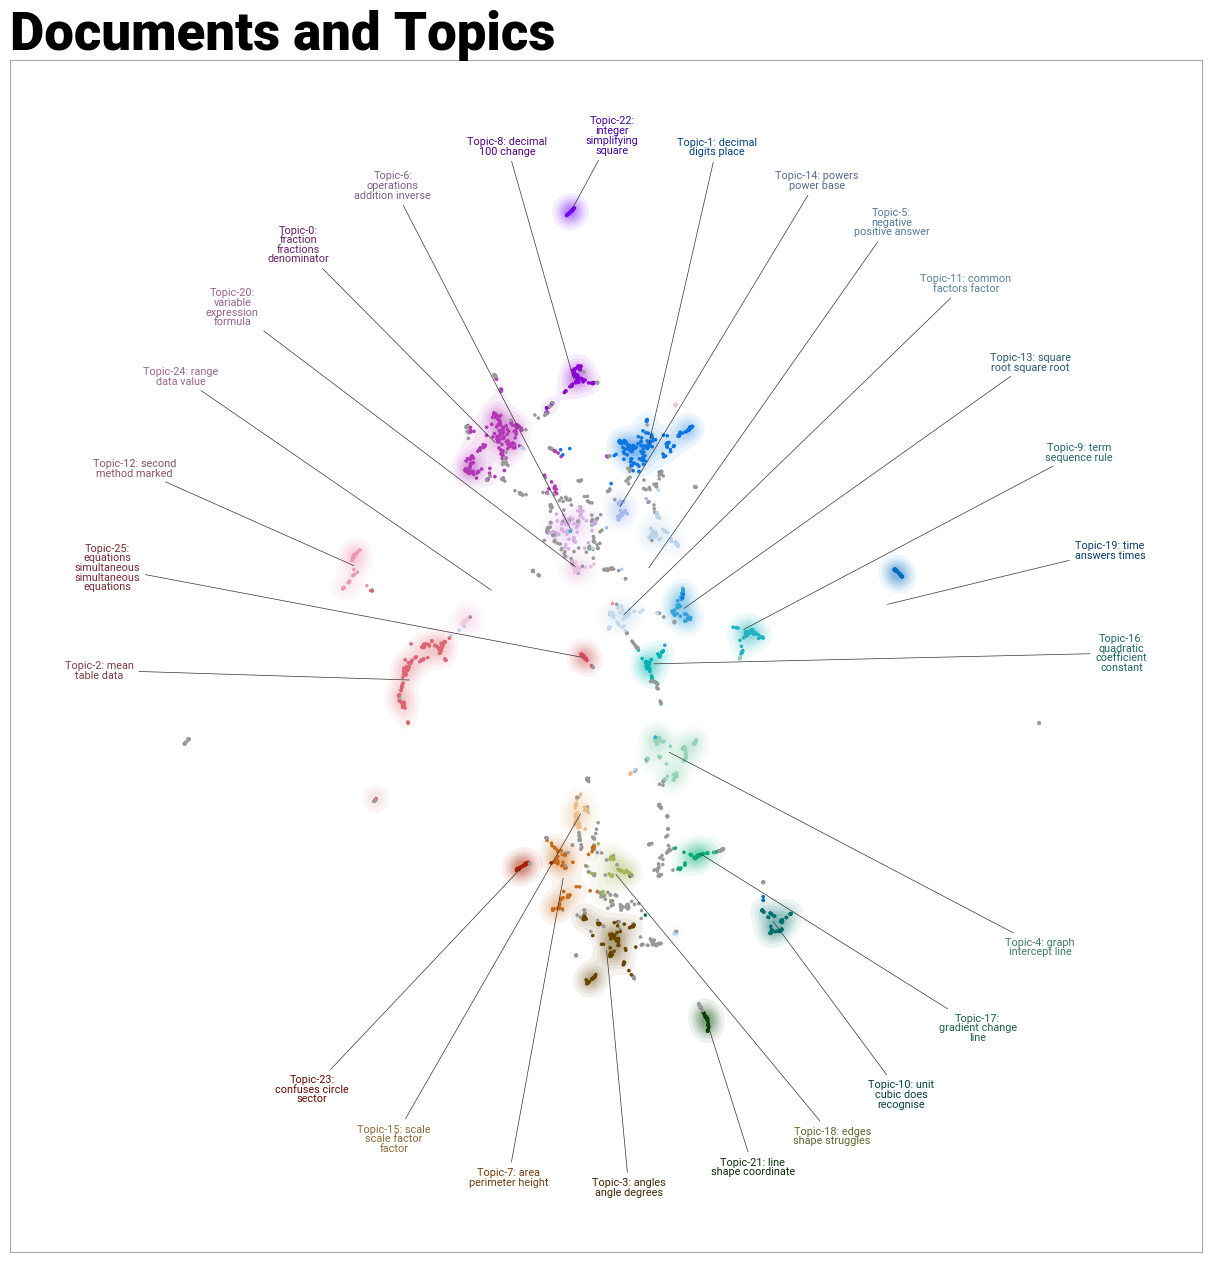

In [14]:
_ = topic_model.visualize_document_datamap(
    df["MisconceptionName"],
    reduced_embeddings=reduced_embeddings,
)

## Topic Similarity

In [15]:
topic_model.visualize_heatmap()

In [16]:
topic_model.visualize_hierarchy()

## Assigning Topics to Misconceptions

In [17]:
df["Topic"] = topic_model.transform(df["MisconceptionName"])[0]

Batches:   0%|          | 0/81 [00:00<?, ?it/s]

2024-11-28 09:50:17,334 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-11-28 09:50:17,339 - BERTopic - Dimensionality - Completed ✓
2024-11-28 09:50:17,340 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-11-28 09:50:17,427 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2024-11-28 09:50:17,669 - BERTopic - Probabilities - Completed ✓
2024-11-28 09:50:17,670 - BERTopic - Cluster - Completed ✓


### Visualizing Topic Distribution


In [18]:
qa_df = pd.read_csv("data/qa-pair-datasettyjgd2rs.csv", usecols=["MisconceptionId"])
qa_df["MisconceptionId"] = qa_df["MisconceptionId"].astype(pd.Int32Dtype())
qa_df.head()

,MisconceptionId
0,1672
1,2142
2,143
3,2142
4,1287


In [19]:
df["Count"] = 0

for i, row in qa_df.iterrows():
    count = qa_df.loc[qa_df["MisconceptionId"] == i, "MisconceptionId"].count()
    df.loc[i, "Count"] = count
    
assert df["Count"].sum() == qa_df.shape[0]
df.head()

,MisconceptionId,MisconceptionName,Topic,Count
0,0.0,Does not know that angles in a triangle sum to...,3.0,1.0
1,1.0,Uses dividing fractions method for multiplying...,0.0,2.0
2,2.0,Believes there are 100 degrees in a full turn,-1.0,2.0
3,3.0,Thinks a quadratic without a non variable term...,16.0,1.0
4,4.0,Believes addition of terms and powers of terms...,14.0,2.0


In [20]:
import plotly.express as px

# Create a combined dataframe for both metrics
topic_distribution = df["Topic"].value_counts().reset_index()
topic_distribution.columns = ["Topic", "Distribution"]

topic_presence = df.groupby("Topic")["Count"].sum().reset_index()
topic_presence.columns = ["Topic", "Presence"]

# Merge the two dataframes
combined_df = topic_distribution.merge(topic_presence, on="Topic")

# Create grouped bar plot
fig = px.bar(
    combined_df,
    x="Topic",
    y=["Distribution", "Presence"],
    barmode="group",
    text_auto=True,
)

fig.update_layout(
    xaxis_title="Topic",
    yaxis_title="Count",
    title="Topic Distribution and Presence",
    width=2000,
    height=500,
    title_x=0.5,
    legend_title="Metric",
)
fig.show()

In [22]:
df["Topic"] = df["Topic"].astype(pd.Int32Dtype())
df["Count"] = df["Count"].astype(pd.Int32Dtype())
df["MisconceptionId"] = df["MisconceptionId"].astype(pd.Int32Dtype())
df.head()


,MisconceptionId,MisconceptionName,Topic,Count
0,0,Does not know that angles in a triangle sum to...,3,1
1,1,Uses dividing fractions method for multiplying...,0,2
2,2,Believes there are 100 degrees in a full turn,-1,2
3,3,Thinks a quadratic without a non variable term...,16,1
4,4,Believes addition of terms and powers of terms...,14,2


In [23]:
df.describe()

,MisconceptionId,Topic,Count
count,2587.0,2587.0,4370.0
mean,1293.0,5.654813,1.0
std,746.946897,7.307434,2.544815
min,0.0,-1.0,0.0
25%,646.5,-1.0,0.0
50%,1293.0,3.0,0.0
75%,1939.5,10.0,1.0
max,2586.0,25.0,54.0


In [25]:
from src.constants.wandb_project import WandbProject
from src.utils.wandb_artifact import log_dataframe_artifact
import wandb

In [26]:
wandb.init(project=WandbProject.PROJECT_NAME, job_type="dataset-upload")
log_dataframe_artifact(
    df,
    artifact_name=WandbProject.MISCONCEPTIONS_DATASET_NAME,
    artifact_type="dataset",
    description="Dataset with topic and count for each misconception",
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: shakleenishfar. Use `wandb login --relogin` to force relogin


<Artifact misconceptions-dataset>